# PyTorch Image Models

PyTorch Image Models (TIMM) is a library for state-of-the-art image classification. With this library you can:

* Choose from 300+ pre-trained state-of-the-art image classification models.
* Train models afresh on research datasets such as ImageNet using provided scripts.
* Finetune pre-trained models on your own datasets, including the latest cutting edge models.

[模型性能](https://paperswithcode.com/lib/timm)

本notebook内容参照：[链接](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)

In [1]:
#!pip install timm

In [1]:
import timm
import torch
import numpy as np
import matplotlib.pyplot as plt

/Users/qianchunqiang/miniforge3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# timm所包含的模型和预训练模型

In [2]:
# 所有模型数量
len(timm.list_models('*'))

964

In [3]:
# 预训练模型数量
len(timm.list_models(pretrained=True))

770

In [7]:
# ResNet类型的模型
timm.list_models('mobi*', pretrained=True)

['mobilenetv2_050',
 'mobilenetv2_100',
 'mobilenetv2_110d',
 'mobilenetv2_120d',
 'mobilenetv2_140',
 'mobilenetv3_large_100',
 'mobilenetv3_large_100_miil',
 'mobilenetv3_large_100_miil_in21k',
 'mobilenetv3_rw',
 'mobilenetv3_small_050',
 'mobilenetv3_small_075',
 'mobilenetv3_small_100',
 'mobilevit_s',
 'mobilevit_xs',
 'mobilevit_xxs',
 'mobilevitv2_050',
 'mobilevitv2_075',
 'mobilevitv2_100',
 'mobilevitv2_125',
 'mobilevitv2_150',
 'mobilevitv2_150_384_in22ft1k',
 'mobilevitv2_150_in22ft1k',
 'mobilevitv2_175',
 'mobilevitv2_175_384_in22ft1k',
 'mobilevitv2_175_in22ft1k',
 'mobilevitv2_200',
 'mobilevitv2_200_384_in22ft1k',
 'mobilevitv2_200_in22ft1k']

# 一般使用

最方便的使用方法是使用`create_model`。

这里，以Resnet-D模型为例。

如果需要修改默认模型下载路径，可以通过设置 TORCH_HOME 环境变量来修改 timm 模型的下载保存路径。

```python
import os

os.environ['TORCH_HOME'] = '/path/to/save/'

# 这里将 TORCH_HOME 环境变量设置为 /path/to/save/，即模型将被下载到该目录下。
```

In [6]:
model = timm.create_model('resnet50d', pretrained=True)

In [7]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

进一步，可以通过获取模型的config，其中，包含，
1. 用于输入数据标准化的统计学参
2. 输出类型数量
3. 网络分类部分的名称

In [8]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'architecture': 'resnet50d'}

## 输入通道可变的图像的预训练模型

[可变通道数的处理](https://timm.fast.ai/models#So-how-is-timm-able-to-load-these-weights?)

In [9]:
# 我们可以通过设置`create_model`的参数`in_chans`来修改模型输入的通道数
m = timm.create_model('resnet50d', pretrained=True, in_chans=1)

# 单通道图像
x = torch.randn(1, 1, 224, 224)

m(x).shape

torch.Size([1, 1000])

这使得我们在输入与预训练模型差异较大的情况下使用预训练模型，不过，直接使用，则不能期望得到相同的性能，而需要进行微调

# 定制化模型

## 修改分类数量

In [10]:
# 前面导入的模型的分类部分的头名称为`fc`
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

但是，这个头名称可能不同模型会有所不同。

可以使用`get_classifier`来获取分类头部，而不需要查看模型信息

In [11]:
model.get_classifier()

Linear(in_features=2048, out_features=1000, bias=True)

返回与前面相同的线性层，最后一层输出1000类

In [12]:
# 通过修改`num_classes`来改变输出类别数量
timm.create_model('resnet50d', pretrained=True, num_classes=10).get_classifier()

Linear(in_features=2048, out_features=10, bias=True)

我们可以看到，timm已经将原先最后一层替换为一新的未训练的我们设置的类别数量的线性层，可以直接用于在我们自己的数据集上微调

-----
如果我们想避免完全创建新的最后一层，可以将类别数量设置为0，这样，将创建一个identity函数作为最后层，这对观察模型倒数第二层的输出很有用

In [13]:
timm.create_model('resnet50d', pretrained=True, num_classes=0).get_classifier()

Identity()

## Global pooling options

从我们的模型config中，我可以看到`pool_size`，即，在分类层前面有全局池化层

In [14]:
model.global_pool

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

这里，我们看到返回`SelectAdaptivePool2d`，这是timm提供的定制化层，支持不同的池化和平铺设置，目前支持的池化选项有：
* avg : Average pooling
* max : Max pooling
* avgmax: the sum of average and max pooling, re-scaled by 0.5
* catavgmax: a concatenation of the outputs of average and max pooling along feature dimension. Note that this will double the feature dimension.
* ‘’ : No pooling is used, the pooling layer is replaced by an Identity operation

In [15]:
pool_types = ['avg', 'max', 'avgmax', 'catavgmax', '']

for pool in pool_types:
    model = timm.create_model('resnet50d', pretrained=True, num_classes=0, global_pool=pool)
    model.eval()
    feature_output = model(torch.randn(1, 3, 224, 224))
    print(f'{pool}: {feature_output.shape}')

avg: torch.Size([1, 2048])
max: torch.Size([1, 2048])
avgmax: torch.Size([1, 2048])
catavgmax: torch.Size([1, 4096])
: torch.Size([1, 2048, 7, 7])


## 修改已有模型

通过使用`reset_classifier`方法，修改已有模型的分类器和池化层

In [16]:
m = timm.create_model('resnet50d', pretrained=True)

print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')
print('------------------')

m.reset_classifier(10, 'max')

print(f'Modified pooling: {m.global_pool}')
print(f'Modified classifier: {m.get_classifier()}')

Original pooling: SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
------------------
Modified pooling: SelectAdaptivePool2d (pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=2048, out_features=10, bias=True)


## 创建新的分类头部

虽然，使用单个线性层作为分类器已经足够得到较好的结果，但是，在下游任务上进行模型微调时，通常会发现使用**略微大一点的头部**能够**提升性能**。

In [17]:
# 首先，创建一个10类别分类的模型
# 为了使用较大的头部，使用catavgmax作为池化，用来为分类器提供更多的信息
model = timm.create_model('resnet50d', pretrained=True, num_classes=10, global_pool='catavgmax')

In [18]:
# 从已有的模型，我们可以获取输入特征数量
num_in_features = model.get_classifier().in_features

num_in_features

4096

现在，我们可以将最后一层替换为我们修改后的分类头部

In [19]:
import torch.nn as nn

model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=10, bias=False)
)

使用哑输入来测试模型，我们可以得到期望的输出。模型现在可以用来训练了。

In [20]:
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 10])

# 特征提取

timm模型可以用来获取多种类型的中间特征，这对在下游任务作为特征提取器。

In [21]:
from PIL import Image
# 转3个通道
image = Image.open("./dog.png").convert('RGB')

In [22]:
image.show()

In [23]:
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2, 0)[None]

In [24]:
image.shape

torch.Size([1, 3, 650, 364])

In [25]:
# 创建模型
model = timm.create_model('resnet50d', pretrained=True)

In [26]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'architecture': 'resnet50d'}

如果我们只对最后的特征图感兴趣，则输出在池化层前的最后的卷积层，  
我们可以使用`forward_features`方法来避开全局池化层和分类层

In [27]:
feature_output = model.forward_features(image)

In [28]:
def visualise_feature_output(t):
    plt.imshow(feature_output[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

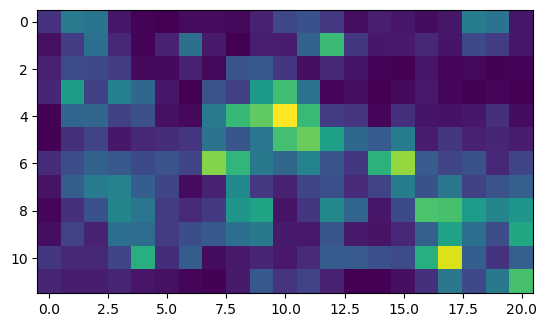

In [29]:
visualise_feature_output(feature_output)

## 多种特征输出

`forward features`方法可以很方便的获取最终的特征图，  
timm同时也提供了将模型用作特征提取backbone，来输出不同层次的特征图。
  
我们在创建模型时，通过设置`features_only=True`来实现将模型用作`feature backbone`。
  
对于大部分模型，以5sride输出，开始于2（但，有些是1或4）
  
通过修改`out_indices` 和 `output_stride` 参数，可以分别修改特征层的指标和stride数


In [30]:
model = timm.create_model('resnet50d', pretrained=True, features_only=True)

我们可以得到特征更多的信息，如，特定的module名称，特征的reduction和通道数

In [31]:
model.feature_info.module_name()

['act1', 'layer1', 'layer2', 'layer3', 'layer4']

In [32]:
model.feature_info.reduction()

[2, 4, 8, 16, 32]

In [33]:
model.feature_info.channels()

[64, 256, 512, 1024, 2048]

In [34]:
# 将图像输入，查看输出
out = model(image)

In [35]:
# 总共5个特征图
len(out)

5

In [36]:
for o in out:
    print(o.shape)

torch.Size([1, 64, 325, 182])
torch.Size([1, 256, 163, 91])
torch.Size([1, 512, 82, 46])
torch.Size([1, 1024, 41, 23])
torch.Size([1, 2048, 21, 12])


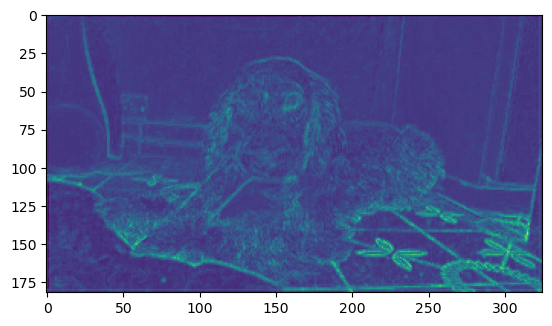

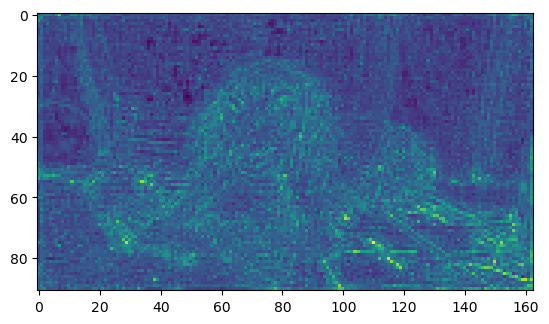

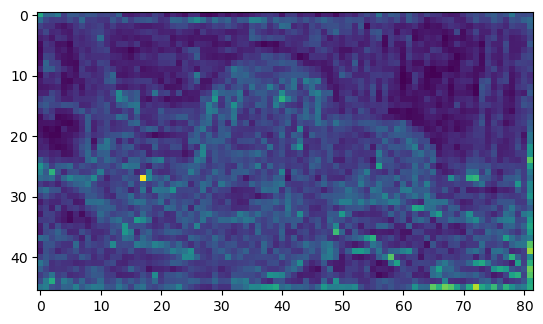

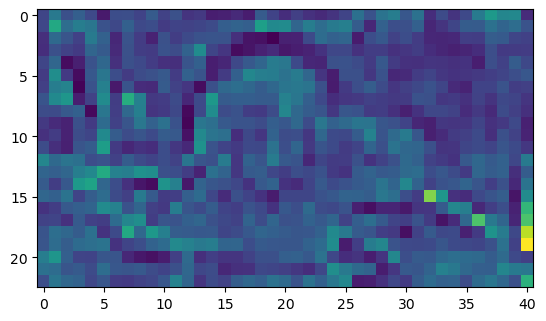

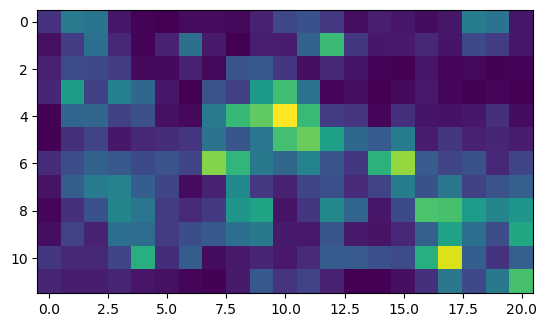

In [37]:
# 查看各个特征图
for o in out:
    plt.imshow(o[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

# 导出不同格式

模型训练完成后，通常推荐导出模型至一优化的格式用于推断。
  
PyTorch提供了多种选择，几乎所有timm模型都是可脚本化（scriptable）和可追踪的（traceable），  
我们可以使用这些格式

## 导出至TorchScript

TorchScript 是一种从 PyTorch 代码创建可序列化和可优化模型的方法； 任何 TorchScript 程序都可以从 Python 进程中保存并加载到没有 Python 依赖性的进程中。
  
我们可以通过两种不同的方式将模型转换为 TorchScript：

* 跟踪：运行代码，记录发生的操作并构造包含这些操作的 ScriptModule。 控制流或动态行为（如 if/else 语句）被删除。
* 脚本：使用脚本编译器对 Python 源代码进行直接分析，将其转换为 TorchScript。 这保留了动态控制流，并且适用于不同大小的输入。
  
TorchScript的[文档](https://pytorch.org/docs/stable/jit.html)和[教程](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html)
  
  
因为大部分timm模型都是可脚本化的，我们可以在创建模型时，设置`scriptable`变量

In [38]:
model = timm.create_model('resnet50d', pretrained=True, scriptable=True)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

在导出模型前，使用`model.eval()`很重要，将模型转入推断模式，
像dropout和batchnorm的表现取决于具体模式

In [39]:
scripted_model = torch.jit.script(model)

In [40]:
scripted_model

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
  )
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (act1): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (act1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule

In [41]:
scripted_model(torch.rand(8, 3, 224, 224)).shape

torch.Size([8, 1000])

## 导出至ONNX

[Open Neural Network eXchange (ONNX)](https://onnx.ai/)是一种表示机器学习模型的开源标准格式。  

我们可以使用 torch.onnx 模块将 timm 模型导出到 ONNX； 使它们能够被支持 ONNX 的许多运行时中的任何一个使用。 如果使用还不是 ScriptModule 的模块调用 torch.onnx.export()，它首先执行与 torch.jit.trace() 等效的操作； 它使用给定的参数执行一次模型并记录在该执行期间发生的所有操作。 这意味着如果模型是动态的，例如，根据输入数据改变行为，导出的模型将不会捕获这种动态行为。 同样，迹线可能仅对特定输入大小有效。
  
  
更多关于ONNX的细节，见[文档](https://pytorch.org/docs/master/onnx.html)


In [42]:
# 为了能够以ONNX格式导出timm模型，
# 可以通过在创建模型时设置`exportable`变量，确保模型是可追踪的
model = timm.create_model('resnet50d', pretrained=True, exportable=True)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

我们使用`torch.onnx.export`来追踪和导出模型

In [43]:
x = torch.randn(2, 3, 224, 224, requires_grad=True)
torch_out = model(x)

In [44]:
# 导出模型
torch.onnx.export(model,                                   # model being
                  x,                                       # model input (or a tuple for multiple inputs)
                 "resnet50d.onnx",                         # where to save the model
                 export_params=True,                       # store the trained parameter weights inside model file
                 opset_version=10,                         # the ONNX version to export the model to
                 do_constant_folding=True,                 # where to execute constant folding for optimization
                 input_names=['input'],                    # the model's input names
                 output_names=['output'],                  # the model's output names
                 dynamic_axes={'input': {0: 'batch_size'}, # variable length axes
                              'output': {0: 'batch_size'}})

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [45]:
import onnx

onnx_model = onnx.load("resnet50d.onnx")
onnx.checker.check_model(onnx_model)

In [46]:
traced_model = torch.jit.trace(model, torch.rand(8, 3, 224, 224))

In [47]:
type(traced_model)

torch.jit._trace.TopLevelTracedModule

In [48]:
traced_model(torch.rand(8, 3, 224, 224)).shape

torch.Size([8, 1000])

# 数据增广(略)

timm 包含许多数据增强转换，可以将它们链接在一起以制作增强管道； 与 TorchVision 类似，这些管道需要 PIL 图像作为输入。

最简单的入门方法是使用 create_transform 工厂函数，让我们在下面探讨如何使用它

# Optimizers

timm提供了大量的优化器，其中一些还没有集成到pytorch中，除了经典的SGD，Adam和Adam之外，还有一些值得注意的：
* AdamP: [相应的文章](https://arxiv.org/abs/2006.08217)
* RMSPropTF： 基于原始Tensorflow实现的RMSProp，并做了[一些微调](https://github.com/pytorch/pytorch/issues/23796).以我的经验来说，这使得比PyTorch版本的训练更稳定
* LAMB：一个关于[ FusedLAMB optimizer from Apex](https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedLAMB)纯的pytorch变种，当使用PyTorch XLA时，兼容TPU
* AdaBelief：[相应论文](https://arxiv.org/abs/2010.07468)，设置超参数的指导在[这](https://github.com/juntang-zhuang/Adabelief-Optimizer#quick-guide)
* MADGRAD: [相应的论文](https://arxiv.org/abs/2101.11075)
* AdaHessian: 一自适应二阶优化器，[相应的论文](https://arxiv.org/abs/2006.00719)

timm所支持的优化器与torch.optim具有相同的交互。

In [49]:
import inspect

import timm.optim

print("timm所支持的所有优化器：")
[cls_name for cls_name, cls_obj in inspect.getmembers(timm.optim) if inspect.isclass(cls_obj) if cls_name != 'Lookahead']

timm所支持的所有优化器：


['AdaBelief',
 'Adafactor',
 'Adahessian',
 'AdamP',
 'AdamW',
 'Lamb',
 'Lars',
 'MADGRAD',
 'Nadam',
 'NvNovoGrad',
 'RAdam',
 'RMSpropTF',
 'SGDP']

创建优化器最简单的方法是使用 `create_optimizer_v2`函数，输入的变量有：
* 模型，或一组参数
* 优化器名称
* 任何需要传入优化器的参数

我们可以使用该函数来创建timm中的优化器实现，也包含torch.optim和来自Apex的fused optimizers

In [50]:
import torch

In [51]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Flatten(0, 1)
)

In [52]:
optimizer = timm.optim.create_optimizer_v2(model, opt='sgd', lr=0.01, momentum=0.8); optimizer, type(optimizer)

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0.8
     nesterov: True
     weight_decay: 0.0
 ),
 torch.optim.sgd.SGD)

我们可以看到，timm没有包含SGD的实现，使用的是`torch.optim`来实现优化器。
  
让我们创建一个在timm实现的优化器

In [53]:
optimizer = timm.optim.create_optimizer_v2(model,
                                          opt='lamb',
                                          lr=0.01,
                                          weight_decay=0.01)

In [54]:
optimizer, type(optimizer)

(Lamb (
 Parameter Group 0
     always_adapt: False
     betas: (0.9, 0.999)
     bias_correction: True
     eps: 1e-06
     grad_averaging: True
     lr: 0.01
     max_grad_norm: 1.0
     trust_clip: False
     weight_decay: 0.0
 
 Parameter Group 1
     always_adapt: False
     betas: (0.9, 0.999)
     bias_correction: True
     eps: 1e-06
     grad_averaging: True
     lr: 0.01
     max_grad_norm: 1.0
     trust_clip: False
     weight_decay: 0.01
 ),
 timm.optim.lamb.Lamb)

我们可以看到使用了`Lamb`的timm实现，我们的权重衰减被应用在参数group1中

## 手动创建优化器

In [55]:
optimizer = timm.optim.RMSpropTF(model.parameters(), lr=0.01)

## Lookahead

timm同时也使得我们可以对优化器应用lookahead算法，[该算法的介绍](https://arxiv.org/abs/1907.08610)和[详细的解释](https://www.youtube.com/watch?v=TxGxiDK0Ccc)。lookahead可以提升学习稳定性和降低其内部优化器的方差，并且其计算开销和内存消耗可忽略

In [56]:
optimizer = timm.optim.create_optimizer_v2(model.parameters(),
                                           opt='lookahead_adam',
                                          lr=0.01
                                          )

In [57]:
# 另一种实现形式
timm.optim.Lookahead(optimizer, alpha=0.5, k=6)

Lookahead (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lookahead_alpha: 0.5
    lookahead_k: 6
    lookahead_step: 0
    lr: 0.01
    maximize: False
    weight_decay: 0.0
)

当使用lookahead时，需要使用下面的代码在训练中，用于更新慢权重

In [58]:
optimizer.sync_lookahead()

下面是一个使用案例

In [59]:
optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)
optimizer = timm.optim.Lookahead(optimizer)

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    optimizer.sync_lookahead()

NameError: name 'num_epochs' is not defined

# Schedulers

At the time of writing, timm contains the following schedulers:

* StepLRScheduler: the learning rate decays every _n_ steps; similar to `torch.optim.lr_scheduler.StepLR`

* MultiStepLRScheduler: a step scheduler that supports multiple milestones at which to reduce the learning rate; similar to `torch.optim.lr_scheduler.MultiStepLR`

* PlateauLRScheduler: reduces the learning rate by a specified factor each time a specified metric plateaus; similar to `torch.optim.lr_scheduler.ReduceLROnPlateau`

* CosineLRScheduler: cosine decay schedule with restarts, as described in [this paper](https://arxiv.org/abs/1608.03983); similar to `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`

* TanhLRScheduler: hyberbolic-tangent decay schedule with restarts, as described in [this paper](https://arxiv.org/abs/1806.01593)

* PolyLRScheduler: polynomial decay schedule, as described in [this paper](https://arxiv.org/abs/2004.05909)
  
许多timm实现的scheduler和PyTorch中的有冲突，timm版本的通常具有不同的默认超参数和提供额外的选项和灵活性；并且所有timm的scheduler都有warmup epochs，同时，还有选项在scheduler中加入随机噪声。另外，CosineLRScheduler和PolyLRScheduler支持衰减选项，如，[k-decay](https://arxiv.org/abs/2004.05909)


## 使用案例

与PyTorch中包含的scheduler不同，timm的shceduler在每个epoch中需要更新两次：
* `.step_update`方法在每个optimizer更新后需要调用
* `.step`方法需要在每个epoch结束时调用

In [60]:
training_epochs = 300
cooldown_epochs = 10
num_epochs = training_epochs + cooldown_epochs

optimizer = timm.optim.AdamP(my_model.parameters(), lr=0.01)
scheduler = timm.scheduler.CosineLRScheduler(optimizer, t_initial=training_epochs)

for epoch in range(num_epochs):

    num_steps_per_epoch = len(train_dataloader)
    num_updates = epoch * num_steps_per_epoch

    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step_update(num_updates=num_updates)

        optimizer.zero_grad()

    scheduler.step(epoch + 1)

NameError: name 'my_model' is not defined

In [61]:
def create_model_and_optimizer():
    model = torch.nn.Linear(2, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    return model, optimizer


In [62]:
model, optimizer = create_model_and_optimizer()

num_epochs=300
num_epoch_repeat = num_epochs//2
num_steps_per_epoch = 10

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                T_0=num_epoch_repeat*num_steps_per_epoch,
                                                                T_mult=1,
                                                                eta_min=1e-6,
                                                                last_epoch=-1)

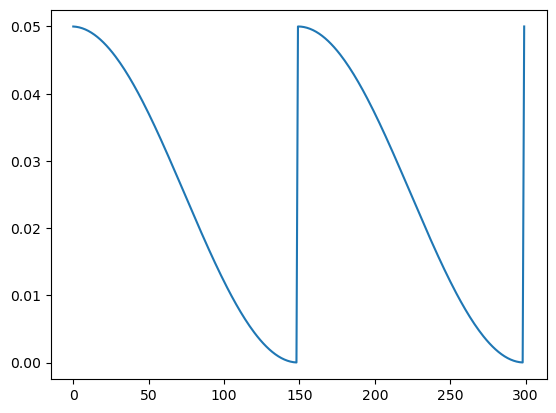

In [63]:
import matplotlib.pyplot as plt

lrs = []

for epoch in range(num_epochs):
    
    for i in range(num_steps_per_epoch):
        scheduler.step()
        
    lrs.append(
        optimizer.param_groups[0]["lr"]
    )

plt.plot(lrs)
plt.show()

## 使用来自timm的`CosineLRScheduler`

* t_initial (int): Number of iterations for the first restart, this is equivalent to `T_0` in torch’s implementation
* lr_min (float): Minimum learning rate, this is equivalent to eta_min in torch’s implementation (Default: `0.`)
* cycle_mul (float): A factor that increases T_{i} after a restart, this is equivalent to T_mult in torch’s implementation (Default: `1`)

为了使得scheduler与Torch表现一致，还需一些额外设置：  

* cycle_limit (int): Limit the number of restarts in a cycle (Default: `1`)
* t_in_epochs (bool): Whether the number iterations is given in terms of epochs rather than the number of batch updates (Default: `True`)

In [64]:
num_epochs=300
num_epoch_repeat = num_epochs/2
num_steps_per_epoch = 10

In [73]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat*num_steps_per_epoch,
                                            lr_min=1e-6,
                                            cycle_limit=num_epoch_repeat+1,
                                            t_in_epochs=False)

In [74]:
def plot_lrs_for_timm_scheduler(scheduler):
    lrs = []

    for epoch in range(num_epochs):
        num_updates = epoch * num_steps_per_epoch

        for i in range(num_steps_per_epoch):
            num_updates += 1
            scheduler.step_update(num_updates=num_updates)

        scheduler.step(epoch + 1)

        lrs.append(optimizer.param_groups[0]["lr"])

    plt.plot(lrs)

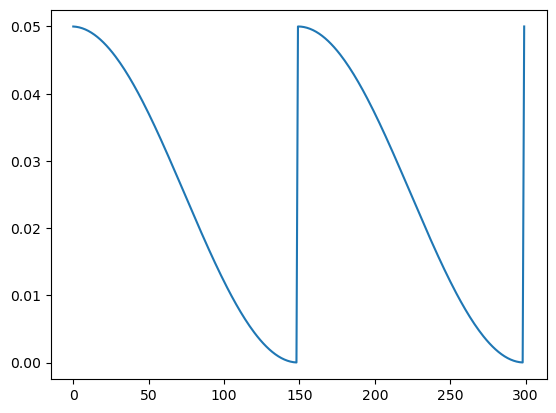

In [75]:
plot_lrs_for_timm_scheduler(scheduler)

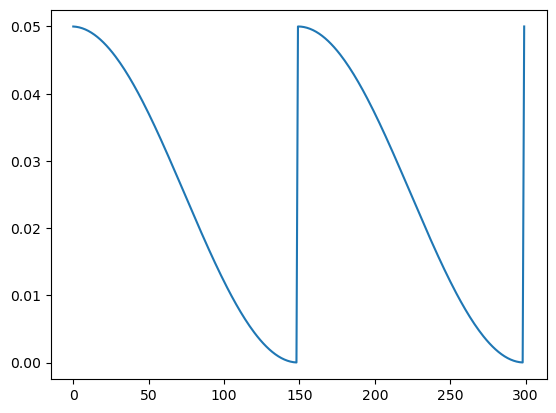

In [76]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-6,
                                            t_in_epochs=True,
                                            cycle_limit=num_epoch_repeat+1)

plot_lrs_for_timm_scheduler(scheduler)

### 增加warm up和noise

可以通过定义`warmup_t`和`warmup_lr_init`变量来设置warm up的epoch数和warm up的初始学习率

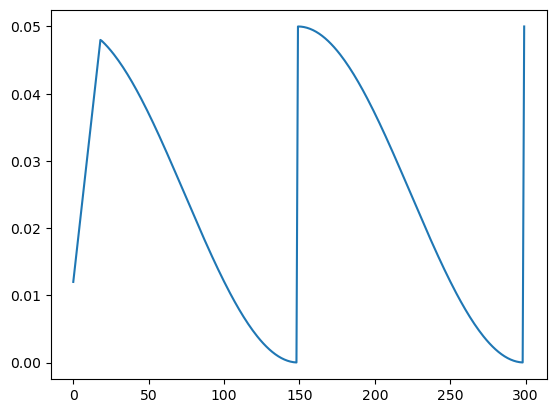

In [77]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            warmup_lr_init=0.01,
                                            warmup_t=20,
                                            cycle_limit=num_epoch_repeat+1)
plot_lrs_for_timm_scheduler(scheduler)

设置`noise_range_t`和`noise_pct`变量来设置噪声

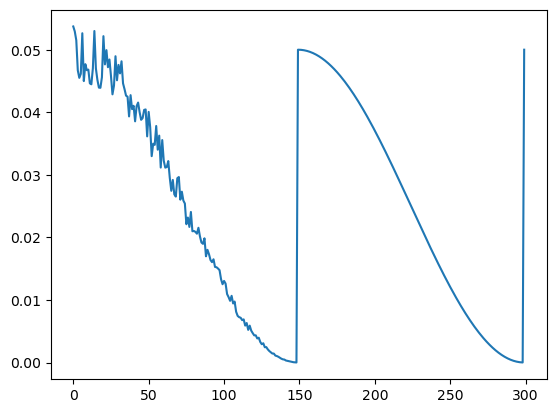

In [78]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            noise_range_t=(0, 150),
                                            noise_pct=0.1,
                                            cycle_limit=num_epoch_repeat+1)
plot_lrs_for_timm_scheduler(scheduler)

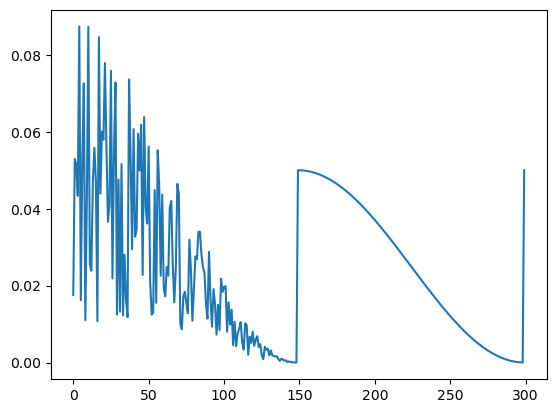

In [79]:
# 可以通过修改noise_pct参数来增大噪声
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            noise_range_t=(0, 150),
                                            noise_pct=0.8,
                                            cycle_limit=num_epoch_repeat+1)
plot_lrs_for_timm_scheduler(scheduler)

### `CosineLRScheduler`的其他选项

除了可以在任何scheduler中使用的warm up和noise，`CosineLRScheduler`还有其他选项。

`cycle_mul`可以用来增加直到下一个restart的时间

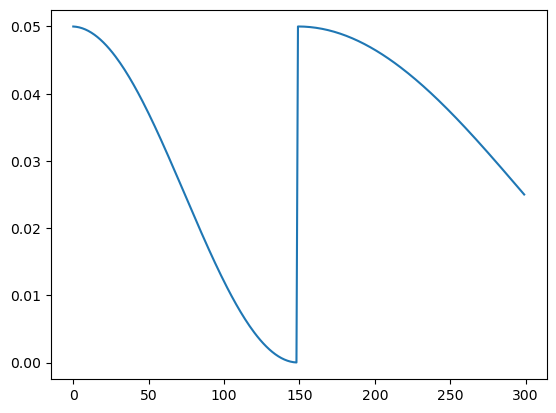

In [80]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat*num_steps_per_epoch,
                                            cycle_limit=num_epoch_repeat+1,
                                            cycle_mul=2.,
                                            t_in_epochs=False)
plot_lrs_for_timm_scheduler(scheduler)

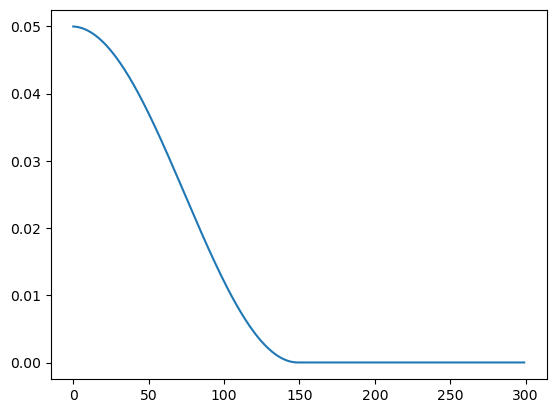

In [81]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            cycle_limit=1)
plot_lrs_for_timm_scheduler(scheduler)

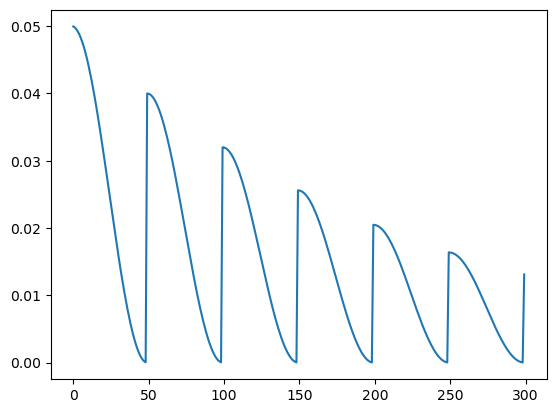

In [82]:
# CosineLRScheduler还支持不同种类的衰减。
# 可以使用cycle_decay减小（或增加）接下去的restart的学习速率
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=50,
                                            lr_min=1e-5,
                                            cycle_decay=0.8,
                                            cycle_limit=num_epoch_repeat+1)
plot_lrs_for_timm_scheduler(scheduler)

我们可以使用`k_decay`参数来控制曲线本身，学习速率的改变速率时通过改变k阶导数，如[这篇论文](https://arxiv.org/abs/2004.05909)的解释

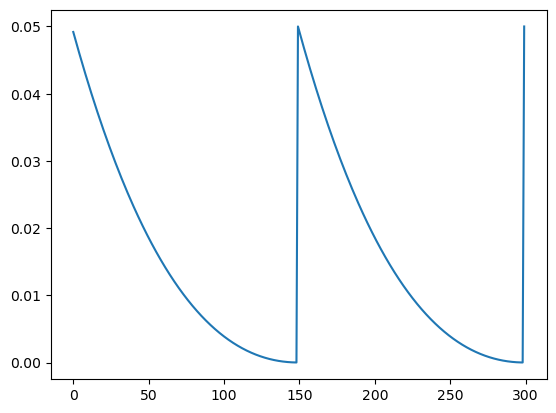

In [83]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            k_decay=0.5,
                                            cycle_limit=num_epoch_repeat+1)
plot_lrs_for_timm_scheduler(scheduler)

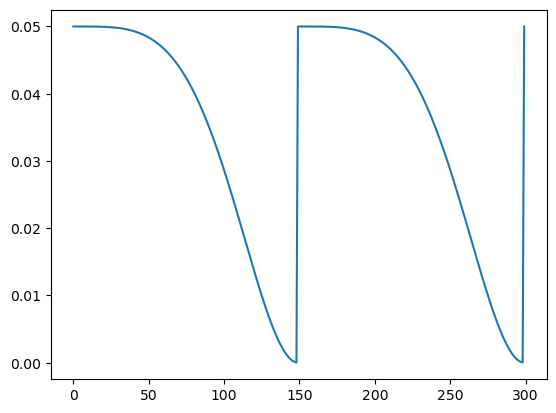

In [84]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            k_decay=2,
                                            cycle_limit=num_epoch_repeat+1)
plot_lrs_for_timm_scheduler(scheduler)

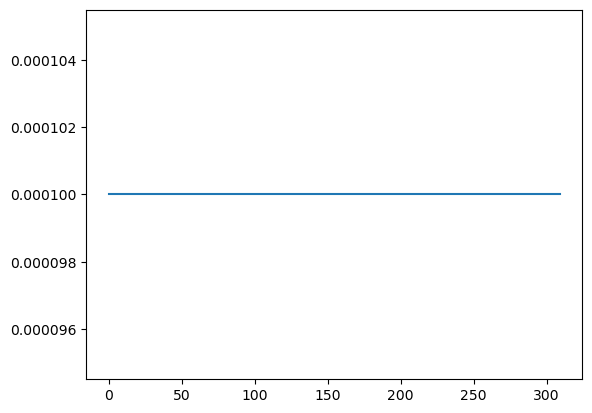

In [85]:
# 如果使用默认参数
model, optimizer = create_model_and_optimizer()

training_epochs = 300
cooldown_epochs = 10
num_epochs = training_epochs + cooldown_epochs
num_steps_per_epoch = 10

lr_sched = timm.scheduler.CosineLRScheduler(optimizer,
                                           t_initial=training_epochs,
                                           cycle_decay=0.5,
                                           lr_min=1e-6,
                                           t_in_epochs=True,
                                           warmup_t=3,
                                           warmup_lr_init=1e-4,
                                           cycle_limit=1,)
plot_lrs_for_timm_scheduler(scheduler)